In [123]:
import numpy as np
import gpstk
from GNSS_TK import *
import matplotlib.pyplot as plt
%matplotlib inline

##Iono gradient WOOS/GARF PRN 26 20.7-21.3 hours 11/20/2003

In [124]:
st1=["data/woos324.03.n","data/woos324.03.o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2=getdata_stationpair(st1,st2,"GPS 26")

In [125]:
print len(IPP1),len(t1),len(Icode1),len(Iphase1),len(VTECphase1),len(ELEV1)
print len(IPP2),len(t2),len(Icode2),len(Iphase2),len(VTECphase2),len(ELEV2)
print min(t1),max(t1)
print min(t2),max(t2)

757 757 757 757 757 757
761 761 761 761 761 761
14459.0 77519.0
14580.0 77550.0


In [126]:
tiempos1=get_obstimes(t1,74520,76680)
tiempos2=get_obstimes(t2,74520,76680)
#Nos quedamos con los datos entre las 20.7 y 21.3 horas
print tiempos1[:10]
print tiempos2[:10]
print len(tiempos1),len(tiempos2)
tiempos1+=1
tiempos2=np.delete(tiempos2,0)
print len(tiempos1),len(tiempos2)
print tiempos1[:10]
print tiempos2[:10]
#Crear una funcion que:
# 1 encuentre el punto en comun a partir del cual comienza y quite las diferencias -->debe ser multiplo de 30 
# y cambiar en los diccionarios las claves :/


[ 74549.  74579.  74609.  74639.  74669.  74699.  74729.  74759.  74789.
  74819.]
[ 74520.  74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.
  74790.]
72 73
72 72
[ 74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.  74790.
  74820.]
[ 74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.  74790.
  74820.]


In [127]:
tcommon=np.intersect1d(tiempos1,tiempos2)
print "Observations: ",np.size(tcommon)

Observations:  72


###First Results: Delay and Slant ZOB GARF

In [128]:
D=[]
gg=[]#gradient
#t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2
IC1,IC2,IPh1,IPh2,IPPs1,IPPs2=[],[],[],[],[],[]
t,EL1,EL2=[],[],[]
print  IPP1[tcommon[0]-1][0] #desfase de 1 segundo -1

-235015.098013


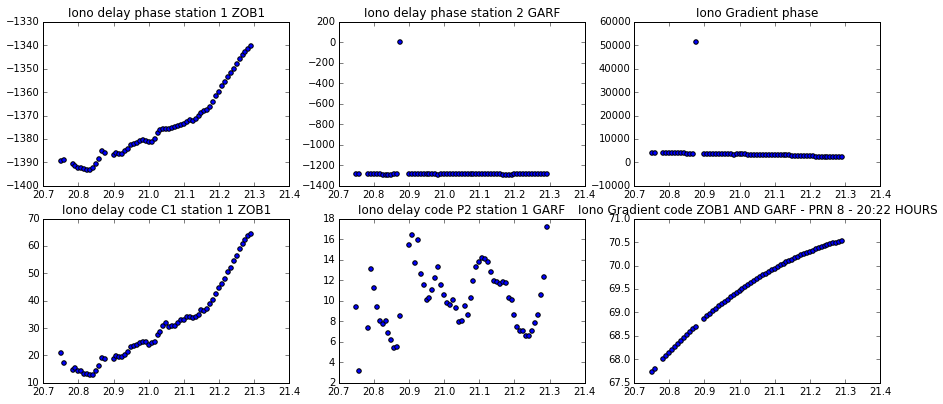

In [129]:
for time in tcommon:
    d=np.sqrt((IPP1[time-1][0]-IPP2[time][0])**2+(IPP1[time-1][1]-IPP2[time][1])**2+(IPP1[time-1][2]-IPP2[time][2])**2)
    if Iphase1[time-1]>-200000 and Iphase1[time-1]<0 and Iphase2[time]>-2000 and Iphase2[time]<100000 : #ese errorcito se soluciona bajando el umbral en getdata
        D.append(d)
        EL1.append(ELEV1[time-1])
        EL2.append(ELEV2[time])
        IC1.append(Icode1[time-1])
        IC2.append(Icode2[time])
        IPh1.append(Iphase1[time-1])
        IPh2.append(Iphase2[time])
        t.append(time)

D=np.array(D)/1000
t=np.array(t)/3600 
IC1=np.array(IC1)
IC2=np.array(IC2)
IP1=np.array(IPh1)
IP2=np.array(IPh2)
EL1=np.array(EL1)
EL2=np.array(EL2)
f1=gpstk.L1_FREQ_GPS
f2=gpstk.L2_FREQ_GPS
alfa=f1**2/(f1**2-f2**2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1 ZOB1")
plt.scatter(t,IP1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2 GARF")
plt.scatter(t,IP2)
plt.subplot(3,3,3)
plt.title("Iono Gradient phase")
DelayP=(alfa*(IP2-IP1)*1000)/D #Km/mm
plt.scatter(t,DelayP)
plt.subplot(3,3,4)
plt.title("Iono delay code C1 station 1 ZOB1")
plt.scatter(t,IC1)
plt.subplot(3,3,5)
plt.title("Iono delay code P2 station 1 GARF")
plt.scatter(t,IC2)
plt.subplot(3,3,6)
plt.title("Iono Gradient code ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
DelayC=(alfa*(IC1-IC2)*1000)/D
plt.scatter(t,D)

#IOD Cycle Slips


In [130]:
jumps1=datajump(IP1,t,2.5) #tgap1
print "Data jumps in slant delay station1 : ",jumps1

jumps2=datajump(IP2,t,2.5) #tgap1
print "Data jumps in  in slant delay station2: ",jumps2

Data jumps in slant delay station1 :  [12 29]
Data jumps in  in slant delay station2:  [13]


In [131]:
print t[jumps1]
print t[jumps2]

[ 20.86666667  21.025     ]
[ 20.875]


In [132]:
print IP1[11],IP1[12],IP1[13] #3 meters of diff
print IP1[28],IP1[29],IP1[30] #7

print IP2[12],IP2[13],IP2[14] #WTF!

-1388.71832998 -1385.25362028 -1385.97899035
-1380.15281722 -1377.24615346 -1376.09778205
-1288.25584596 0.0 -1284.93846938


##Continuous arcs are divided into "several" subarcs
Using de datajumps we split our arc into miniarcs

In [133]:
miniarcs1,ntimes1=sub_arcs(IP1,t,jumps1)
print "Total subarcs=",len(miniarcs1)
for i in range(len(miniarcs1)):
    print "Arc ",i," has ",len(miniarcs1[i])," elements"

Total subarcs= 3
Arc  0  has  12  elements
Arc  1  has  17  elements
Arc  2  has  33  elements


In [134]:
miniarcs2,ntimes2=sub_arcs(IP2,t,jumps2)
print "Total subarcs=",len(miniarcs2)
for i in range(len(miniarcs2)):
    print "Arc ",i," has ",len(miniarcs2[i])," elements" 

Total subarcs= 2
Arc  0  has  13  elements
Arc  1  has  49  elements


##Short arc Removal
Also, miniarcs with less than 10 elements, or five minutes are removed. **The short arcs need to be discarded because leveling errors for those arcs are typically large and cause ionospheric delay estimation errors. **

In [135]:
print "Number of subarcs: ",len(miniarcs1)
miniarcs1,ntimes1=remove_short(miniarcs1,ntimes1)
print "Number of subarcs after shirtarc removal: ",len(miniarcs1)

Number of subarcs:  3
Number of subarcs after shirtarc removal:  3


In [136]:
print "Number of subarcs: ",len(miniarcs2)
miniarcs2,ntimes2=remove_short(miniarcs2,ntimes2)
print "Number of subarcs after shirtarc removal: ",len(miniarcs2)

Number of subarcs:  2
Number of subarcs after shirtarc removal:  2


##Polinomial fit & Outlier detection and Removal
###Polinomial fit

In [137]:
def poly_fit(lI,time):
    N=10 #window 
    tPoly=[]
    Poly=[]
    for i in range(0,lI.size,N): 
        x=np.array(time[i:i+N])
        y=np.array(lI[i:i+N])
        z= np.polyfit(x,y,2)
        p = np.poly1d(z)
        for i in range(x.size):
            Poly.append(p(x[i]))
            tPoly.append(x[i]) 
    Poly=np.array(Poly)
    residual=lI-Poly
    jumps=datajump(residual,time,0.8)
    if jumps.size>0:
        pslip=np.argmax(residual[jumps])
        pslip=jumps[pslip]
    else:
        pslip=None
    return Poly,pslip

def outlier_detect(L,times,k=10):
    outliers=[] #set of outlier factors for every element in L=L1-L2
    for i in range(0,L.size):
        if i<(k/2+1):
            neighbours=np.hstack((L[0:i],L[i+1:i+(k/2)+1])) #neighbours around i, without i
            tn=np.hstack((times[0:i],times[i+1:i+(k/2)+1]))
    
        elif i>L.size-(k/2+1):
            neighbours=np.hstack((L[i-k/2:i],L[i+1:L.size+1]))
            tn=np.hstack((times[i-k/2:i],times[i+1:L.size+1])) #times neighbour
            
        else:
            neighbours=np.hstack((L[i-k/2:i],L[i+1:i+(k/2)+1]))
            tn=np.hstack((times[i-k/2:i],times[i+1:i+(k/2)+1]))
        
        OFt=0
        deno=np.sum(1/(np.abs(times[i]-tn)*1.0))#denominador de Wpq para elemento i
        for neighbour in range(neighbours.size): 
            if times[neighbour]!=times[i]:
                Wpq=1/np.abs(times[i]-times[neighbour])
                Wpq=Wpq/deno
                OFt+=(Wpq*np.abs(L[i]-L[neighbour]))
        outliers.append(OFt) 
    outliers=np.array(outliers)
    oslip=np.argmax(outliers) #term with biggest outlier factor
    
    return outliers,oslip
    
#if the biggest slip computed with polifit and outlier factor is the same
def fixslip(t,L,threshold=0.8):
    Poly,pslip=poly_fit(L,t) #residuals bigger than threshold 0.8, and biggest slip detected
    confirmed=[]#confirmed outliers
    while len(Poly)!=0: #if there are outliers
        __,oslip=outlier_detect(L,t*3600) #biggest slip detected with outlier factor
        if pslip==oslip and pslip not in confirmed and pslip!=None:
            confirmed.append(pslip) #recorded as an outlier
            L=np.delete(L,pslip) #remove outlier
            t=np.delete(t,pslip)
            print "Poly: ",pslip,"Outlier factor: ",oslip
        Poly,npslip=poly_fit(L,t)  
        if npslip==pslip:
            break
        else:
            pslip=npslip
    return L,t,confirmed

Station 1 subarcs
Biggest Slip detected with polinomyal fit:  1 1 20.7583333333
Biggest Slip detected with polinomyal fit:  16 28 21.0166666667
Biggest Slip detected with polinomyal fit:  1 30 21.1583333333


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


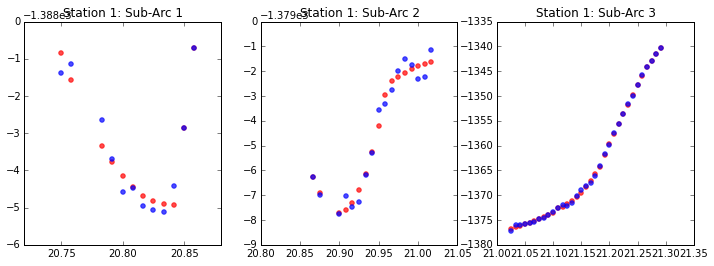

In [138]:
print "Station 1 subarcs"
plt.figure(figsize=(12,4))
P11,pslip11=poly_fit(miniarcs1[0],ntimes1[0])
plt.subplot(1,3,1)
plt.title("Station 1: Sub-Arc 1")
plt.scatter(ntimes1[0],P11,color="red",alpha=.7)
plt.scatter(ntimes1[0],miniarcs1[0],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip11,pslip11,ntimes1[0][pslip11] #compare with station 2 slip,index[if all three arcs where united],time

P12,pslip12=poly_fit(miniarcs1[1],ntimes1[1])
plt.subplot(1,3,2)
plt.title("Station 1: Sub-Arc 2")
plt.scatter(ntimes1[1],P12,color="red",alpha=.7)
plt.scatter(ntimes1[1],miniarcs1[1],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip12,jumps1[0]+pslip12,ntimes1[1][pslip12]

P13,pslip13=poly_fit(miniarcs1[2],ntimes1[2])
plt.subplot(1,3,3)
plt.title("Station 1: Sub-Arc 3")
plt.scatter(ntimes1[2],P13,color="red",alpha=.7)
plt.scatter(ntimes1[2],miniarcs1[2],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip13,jumps1[1]+pslip13,ntimes1[2][pslip12]

Station 2 subarcs
Biggest Slip detected with polinomyal fit:  1 1 20.7583333333
Biggest Slip detected with polinomyal fit:  16 29 21.025


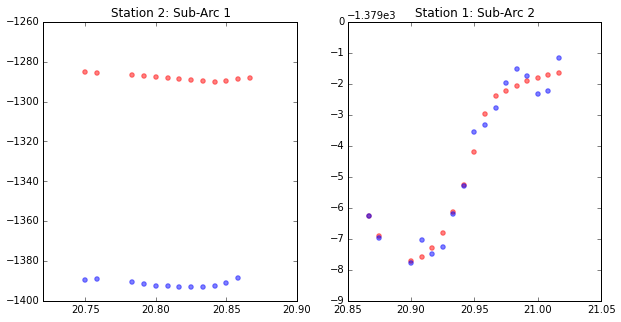

In [139]:
print "Station 2 subarcs"
plt.figure(figsize=(10,5))
P21,pslip21=poly_fit(miniarcs2[0],ntimes2[0])
plt.subplot(1,2,1)
plt.title("Station 2: Sub-Arc 1")
plt.scatter(ntimes2[0],P21,color="red",alpha=.5)
plt.scatter(ntimes1[0],miniarcs1[0],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip21,pslip21,ntimes2[0][pslip21]

P22,pslip22=poly_fit(miniarcs1[1],ntimes1[1])
plt.subplot(1,2,2)
plt.title("Station 1: Sub-Arc 2")
plt.scatter(ntimes1[1],P22,color="red",alpha=.5)
plt.scatter(ntimes1[1],miniarcs1[1],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip22,jumps2[0]+pslip22,ntimes2[1][pslip22]

###Outlier Factor 

In [140]:
outliers11,oslip11=outlier_detect(miniarcs1[0],ntimes1[0]*3600) #mandarle el jump acá ? O.o
print "Elements in OFt: ",outliers11.size
print "Biggest slip detected in: ",oslip11
print miniarcs1[0][oslip11]
print ntimes1[0][oslip11]

Elements in OFt:  12
Biggest slip detected in:  2
-1390.63416907
20.7833333333


In [141]:
outliers12,oslip12=outlier_detect(miniarcs1[1],ntimes1[1]*3600)
print "Elements in OFt: ",outliers12.size
print "Biggest slip detected in: ",oslip12
print miniarcs1[1][oslip12]
print ntimes1[1][oslip12]

Elements in OFt:  17
Biggest slip detected in:  8
-1382.54630185
20.95


In [142]:
outliers13,oslip13=outlier_detect(miniarcs1[2],ntimes1[2]*3600)
print "Elements in OFt: ",outliers13.size
print "Biggest slip detected in: ",oslip13
print miniarcs1[2][oslip13]
print ntimes1[2][oslip13]

Elements in OFt:  33
Biggest slip detected in:  27
-1347.8691948
21.25


In [143]:
outliers21,oslip21=outlier_detect(miniarcs2[0],ntimes2[0]*3600)
print "Elements in OFt: ",outliers21.size
print "Biggest slip detected in: ",oslip21
print miniarcs2[0][oslip21]
print ntimes2[0][oslip21]

Elements in OFt:  13
Biggest slip detected in:  2
-1285.34776924
20.7833333333


In [144]:
outliers22,oslip22=outlier_detect(miniarcs2[1],ntimes2[1]*3600)
print "Elements in OFt: ",outliers22.size
print "Biggest slip detected in: ",oslip22
print miniarcs2[1][oslip22]
print ntimes2[1][oslip22]

Elements in OFt:  49
Biggest slip detected in:  0
0.0
20.875


In [145]:
Lnew11,tnew11,outliers11=fixslip(ntimes1[0],miniarcs1[0],threshold=0.8)
print outliers11,len(miniarcs1[0]),len(Lnew11)
Lnew12,tnew12,outliers12=fixslip(ntimes1[1],miniarcs1[1],threshold=0.8)
print outliers12,len(miniarcs1[1]),len(Lnew12)
Lnew13,tnew13,outliers13=fixslip(ntimes1[2],miniarcs1[2],threshold=0.8)#same O.o is this good or bad?
print outliers13,len(miniarcs1[2]),len(Lnew13)

[] 12 12
[] 17 17
[] 33 33


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [146]:
Lnew21,tnew21,outliers21=fixslip(ntimes2[0],miniarcs2[0],threshold=0.8)
print outliers21,len(miniarcs2[0]),len(Lnew21)
Lnew22,tnew22,outliers22=fixslip(ntimes2[1],miniarcs2[1],threshold=0.8)  #aquí si removió un factor
print outliers22,len(miniarcs2[1]),len(Lnew22),jumps2[0]#13th element should be removed from both stations

[] 13 13
Poly:  0 Outlier factor:  0
[0] 49 48 13


In [147]:
#Station 1 jumps1 [12 29]
#0-11
print jumps1[0]
print len(ntimes1[0])
Lfactor11,new_IPHASE_arc11=levelphase(IC1[:jumps1[0]],miniarcs1[0],EL1[:jumps1[0]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor11,new_IPHASE_arc11.size

12
12
Leveling factor:  1406.37539122 12


In [148]:
print jumps1[1]-jumps1[0]
print len(ntimes1[1])
Lfactor12,new_IPHASE_arc12=levelphase(IC1[jumps1[0]:jumps1[1]],miniarcs1[1],EL1[jumps1[0]:jumps1[1]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor12,new_IPHASE_arc12.size

17
17
Leveling factor:  1405.46642293 17


In [149]:
print jumps1[0] #till the final index
print len(ntimes1[2])
Lfactor13,new_IPHASE_arc13=levelphase(IC1[jumps1[1]:],miniarcs1[2],EL1[jumps1[1]:]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor13,new_IPHASE_arc13.size

12
33
Leveling factor:  1405.20178871 33


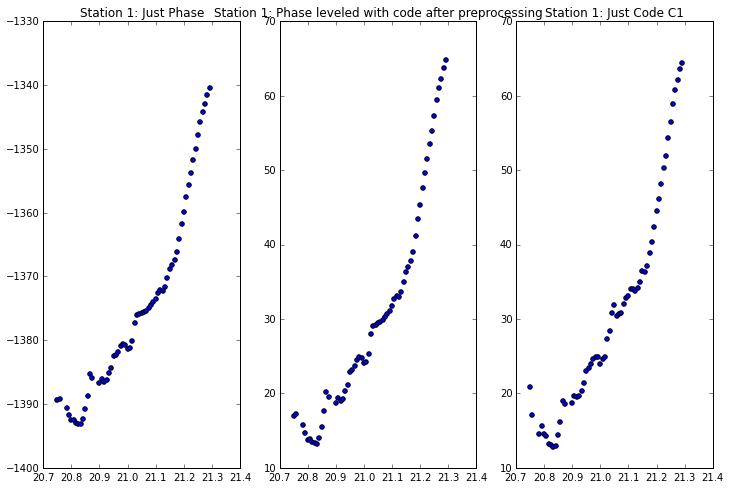

In [150]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 1: Just Phase")
plt.scatter(t,IP1)

plt.subplot(1,3,2)
plt.title("Station 1: Phase leveled with code after preprocessing")
plt.scatter(ntimes1[0],new_IPHASE_arc11)
plt.scatter(ntimes1[1],new_IPHASE_arc12)
plt.scatter(ntimes1[2],new_IPHASE_arc13)

plt.subplot(1,3,3)
plt.title("Station 1: Just Code C1")
plt.scatter(t,IC1)

In [151]:
print len(ntimes2[0])
Lfactor21,new_IPHASE_arc21=levelphase(IC2[:jumps2[0]],miniarcs2[0],EL2[:jumps2[0]]) #IC2 code delay on station2
print "Leveling factor: ",Lfactor21,new_IPHASE_arc21.size

13
Leveling factor:  1295.83680304 13


In [152]:
#13-62
print len(ntimes2[1])
Lfactor22,new_IPHASE_arc22=levelphase(IC2[jumps2[0]:],miniarcs2[1],EL2[jumps2[0]:]) #IC2 code delay on station2
print "Leveling factor: ",Lfactor22,new_IPHASE_arc22.size

49
Leveling factor:  1271.12600272 49


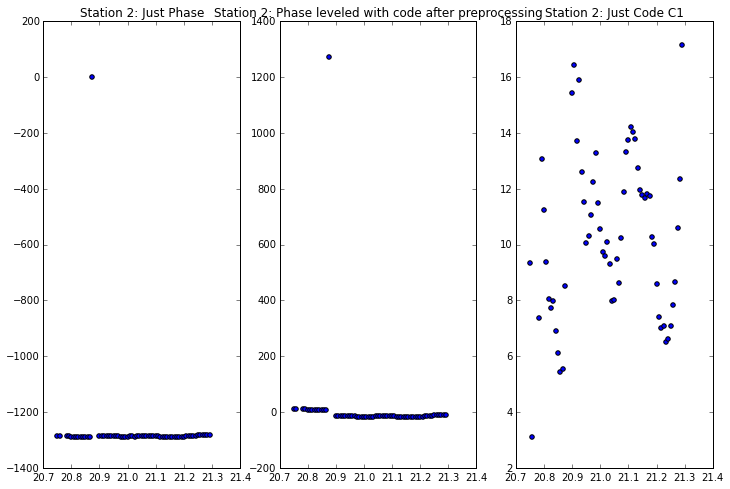

In [153]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 2: Just Phase")
plt.scatter(t,IP2)

plt.subplot(1,3,2)
#plt.ylim(-2,20)
plt.title("Station 2: Phase leveled with code after preprocessing")
plt.scatter(ntimes2[0],new_IPHASE_arc21)
plt.scatter(ntimes2[1],new_IPHASE_arc22)

plt.subplot(1,3,3)
plt.title("Station 2: Just Code C1")
plt.scatter(t,IC2)

In [154]:
ntimes1=np.hstack((ntimes1[0],ntimes1[1],ntimes1[2])) 
new_IPHASE_arc1=np.hstack((new_IPHASE_arc11,new_IPHASE_arc12,new_IPHASE_arc13 )) 

ntimes2=np.hstack((ntimes2[0],ntimes2[1])) 
new_IPHASE_arc2=np.hstack((new_IPHASE_arc21,new_IPHASE_arc22 )) 

In [155]:
print ntimes1.size,new_IPHASE_arc1.size
print ntimes2.size,new_IPHASE_arc2.size

62 62
62 62


In [ ]:
new_IPHASE_arc1=np.delete(new_IPHASE_arc1,13)
ntimes1=np.delete(ntimes1,13)
new_IPHASE_arc2=np.delete(new_IPHASE_arc2,13) #osea que fix no esta borrando? O.o
ntimes2=np.delete(ntimes2,13)
D=np.delete(D,13)

60
60 60


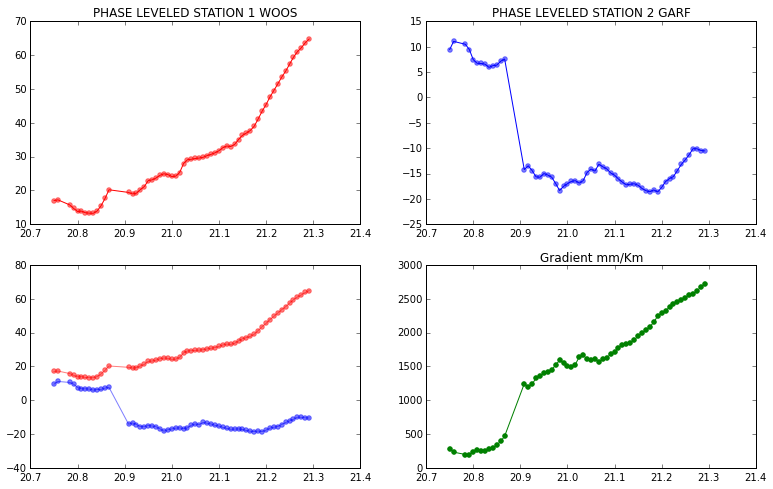

In [157]:
plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("PHASE LEVELED STATION 1 WOOS")
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red")
plt.subplot(2,2,2)
plt.title("PHASE LEVELED STATION 2 GARF")
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue")
plt.subplot(2,2,3)
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
##aELIMINAR TAMBIEN EL SHORT ARC EN LA OTRA ESTACION Y EN LA DISTANCIA ENTRE IPPS
print len(D)
print len(new_IPHASE_arc1),len(new_IPHASE_arc2)

gradient=alfa*(-new_IPHASE_arc2+new_IPHASE_arc1)*1000 
plt.subplot(2,2,4)
plt.title("Gradient mm/Km")
plt.scatter(ntimes1,gradient/D,color="green")
plt.plot(ntimes1,gradient/D,color="green")
